In [58]:
#1 Menambahkan Library yang akan kita butuhkan
import numpy as np
import pandas as pd
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score
import matplotlib.pyplot as plt

In [59]:
#2 Load dataset
train_df = pd.read_csv(r"D:\Python seno\emnist-letters-train.csv\emnist-letters-train.csv")

# Pisahkan label & pixel
# format df.iloc[baris, kolom]
labels = train_df.iloc[:,0].values        # shape: (n_samples,)
images = train_df.iloc[:,1:].values       # shape: (n_samples, 784)

In [60]:
print("Jumlah sample:", labels.shape[0])

Jumlah sample: 88799


In [61]:
print("Dimensi pixel per sample:", images.shape[1])

Dimensi pixel per sample: 784


In [62]:
train_df

,23,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.406,0.407,0.408,0.409,0.410,0.411,0.412,0.413,0.414,0.415
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88794,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
88795,21,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
88796,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
88797,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
#3 membagi sample per letter sebanyak 500, sehingga total ada 13K sample dari 88.8k sample

# format df.iloc[baris, kolom]
# simpan list kecil untuk tiap label
samples_per_class = 500
sampled_df = pd.DataFrame()

for label in range(1, 27):  # 1=A, 2=B, ..., 26=Z
    subset = train_df[train_df.iloc[:,0] == label]
    sampled = subset.sample(n=samples_per_class, random_state=42)
    sampled_df = pd.concat([sampled_df, sampled])

In [64]:
# cek
print(sampled_df.shape)  # harus (13000, 785)

(13000, 785)


In [65]:
sampled_df.shape[0]

13000

In [66]:
#4 Ambil labels & images dari 13K sampel hasil sampling
labels_sampled = sampled_df.iloc[:, 0].values
images_sampled = sampled_df.iloc[:, 1:].values

In [67]:
labels_sampled.shape

(13000,)

In [68]:
images_sampled.shape

(13000, 784)

In [69]:
#5 Ekstrak HOG feature dari 13k data yang udah kita ambil tadi

hog_features = []

for i in range(len(images_sampled)):
    img = images_sampled[i].reshape(28,28)  # reshape 1D → 2D per gambar
    feature = hog(img, orientations=9, pixels_per_cell=(8,8),
                  cells_per_block=(2,2), block_norm='L2-Hys')
    hog_features.append(feature)

hog_features = np.array(hog_features)

In [70]:
print(hog_features.shape)

(13000, 144)


In [71]:
#6 Mempersiapkan data untuk SVM kernel linear

X = hog_features         # shape: (13000, 144)
y = labels_sampled       # shape: (13000,)

svm_clf = SVC(kernel='linear', C=1.0, random_state=42)

In [72]:
# setting batch
batch_size = 100
n_samples = X.shape[0]
save_file = "y_results_partial.csv"

In [73]:
# resume checkpoint jika ada batch
try:
    df = pd.read_csv(save_file)
    start_index = len(df)  # mulai dari baris berikutnya
    y_true_all = df["y_true"].tolist()
    y_pred_all = df["y_pred"].tolist()
    print(f"Resuming from sample index {start_index}")
except FileNotFoundError:
    start_index = 0
    y_true_all = []
    y_pred_all = []
    print("Starting from scratch")

Starting from scratch


In [74]:
from tqdm import tqdm

In [75]:
# Loop LOOCV per batch (500)

for i in tqdm(range(start_index, n_samples), total=n_samples, initial=start_index, desc="LOOCV Progress"):
    X_train = np.delete(X, i, axis=0)   # semua kecuali sample ke-i
    y_train = np.delete(y, i, axis=0)
    X_test = X[i].reshape(1, -1)
    y_test = y[i]
    
    svm_clf.fit(X_train, y_train)
    y_pred = svm_clf.predict(X_test)
    
    y_true_all.append(y_test)
    y_pred_all.append(y_pred[0])
    
    # checkpoint tiap 500 iterasi
    if (i+1) % 100 == 0:
        pd.DataFrame({"y_true": y_true_all, "y_pred": y_pred_all}).to_csv(save_file, index=False)

LOOCV Progress: 100%|██████████████████████████████████████████████████████████| 13000/13000 [7:22:35<00:00,  2.04s/it]


In [86]:
# mengambil data y hasil LOOCV tadi

y_true = y_true_all
y_pred = y_pred_all

In [87]:
#8 Menampilkan Confusion Matix, ACC, PREC, F1
conf_matrix = confusion_matrix(y_true, y_pred)

In [89]:
conf_matrix

array([[376,   8,   6,  10,   3,   0,   7,   9,   1,   0,   1,   0,   6,
         16,   4,   0,  33,   3,   0,   3,   3,   0,   3,   0,   1,   7],
       [ 14, 396,   1,   7,   2,   1,   5,  37,   1,   0,   4,   4,   0,
          1,   4,   1,   6,   8,   3,   0,   0,   0,   1,   0,   0,   4],
       [  5,   0, 425,   0,  38,   3,   7,   0,   2,   1,   0,   2,   0,
          1,   7,   0,   3,   4,   2,   0,   0,   0,   0,   0,   0,   0],
       [ 14,   9,   0, 423,   0,   0,   0,   6,   6,   8,   0,   2,   0,
         10,  15,   2,   0,   0,   1,   2,   1,   0,   0,   0,   0,   1],
       [  8,   3,  30,   0, 406,  26,   8,   0,   1,   1,   0,   0,   0,
          0,   5,   0,   2,   5,   1,   0,   0,   0,   1,   0,   0,   3],
       [  3,   3,   6,   2,   8, 419,   3,   1,   2,   1,   2,   2,   0,
          0,   0,   8,   2,  10,   4,  21,   0,   0,   0,   1,   0,   2],
       [ 12,  13,  22,   0,   9,   6, 320,   2,   2,   3,   0,   0,   1,
          0,   1,   1,  84,   1,  11,   3,   

In [79]:
from mlxtend.plotting import plot_confusion_matrix

In [80]:
class_names = [chr(i) for i in range(65, 91)]  # A-Z

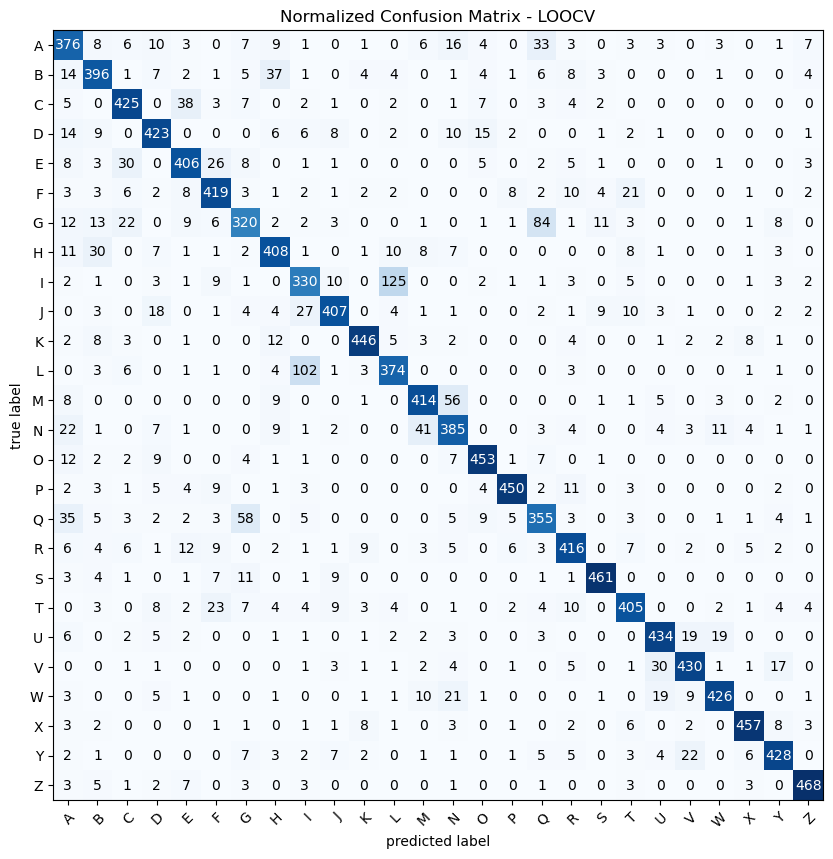

In [91]:
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, class_names=class_names, figsize=(12,10))

plt.title("Normalized Confusion Matrix - LOOCV")
plt.show()

In [92]:
#9 Menampilkan Accuracy
accuracy = accuracy_score(y_true, y_pred)

In [93]:
accuracy

0.824

In [94]:
#10 Menampilkan Presisi
precision = precision_score(y_true, y_pred, average= 'macro')

In [95]:
precision

0.8258210632487528

In [96]:
#11 Menampilkan F1 Score
f1 = f1_score(y_true, y_pred, average='macro')

In [97]:
f1

0.8245359614852268